In [1]:
from utils.runtime import connect_to_db, setup_plot_params

brew  = connect_to_db()
q  = '''

SELECT account_number,
       interval_start,
       price,
       kwh,
       price / kwh AS price_per_kwh
  FROM ampion_bills
 ORDER BY 1, 2

'''

df = brew.query(q).to_df()

df

,account_number,interval_start,price,kwh,price_per_kwh
0,30010320353,2022-09-01,612.40,3668,0.166957
1,30010320353,2022-10-13,323.99,2009,0.161269
2,30010320353,2022-11-10,245.61,1523,0.161267
3,30010320353,2022-12-13,56.70,271,0.209225
4,30010320353,2023-01-12,112.15,536,0.209235
...,...,...,...,...,...
73,35012790198,2023-04-12,147.31,704,0.209247
74,35012790198,2023-05-11,273.06,1305,0.209241
75,35012790198,2023-06-12,202.22,968,0.208905
76,35012790198,2023-07-13,223.93,1092,0.205064


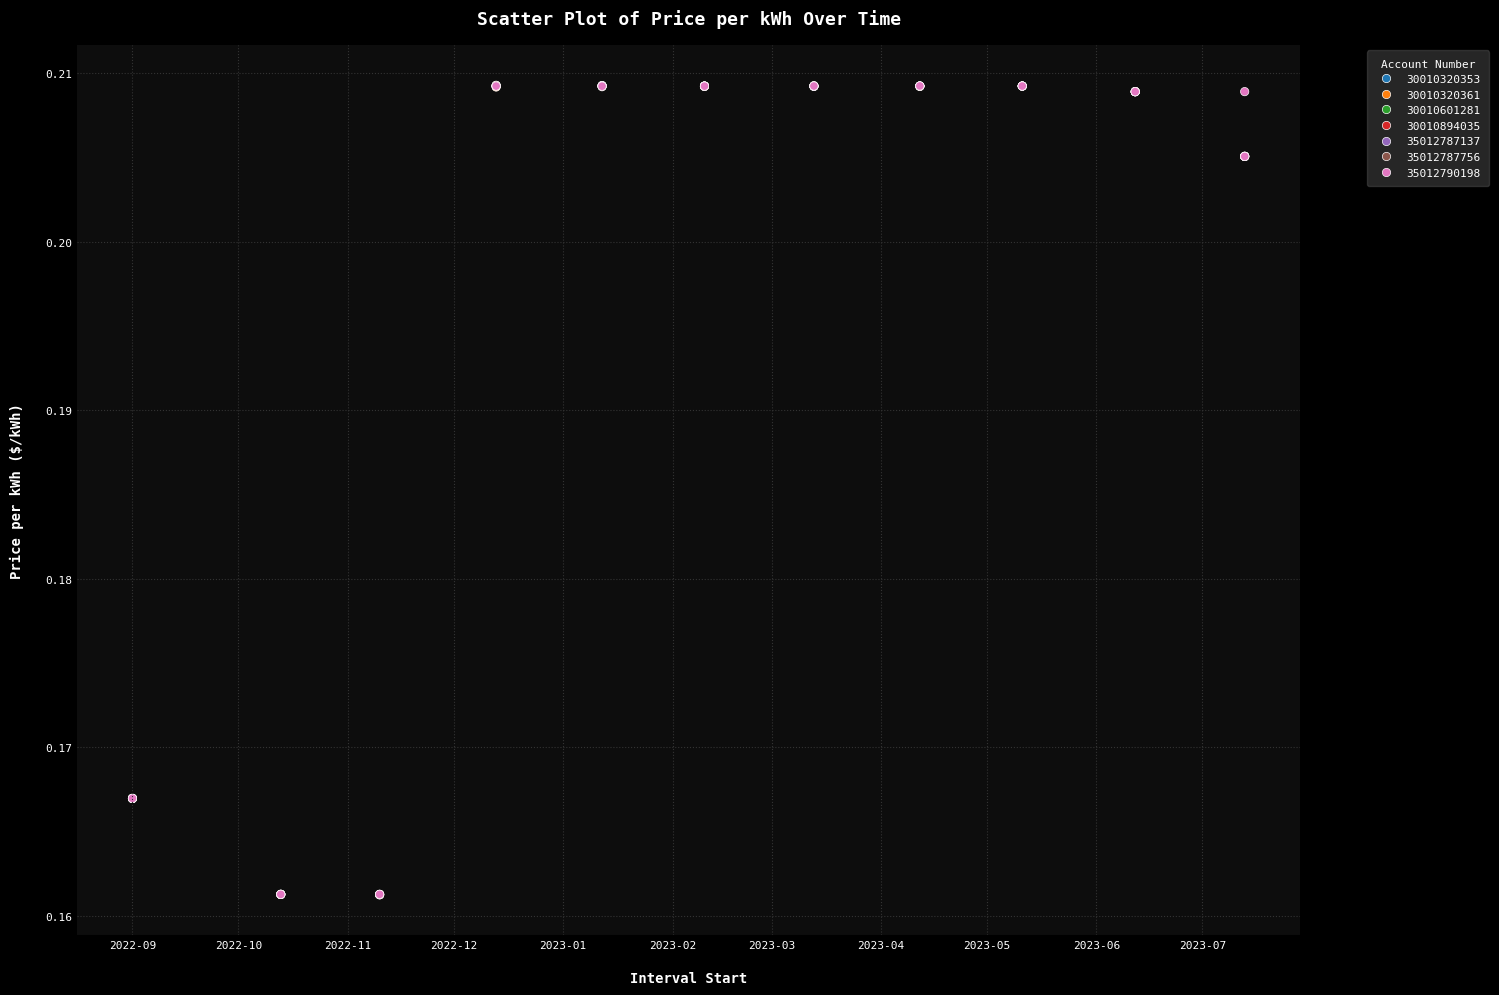

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame
# Convert 'interval_start' to datetime for proper plotting
df['interval_start'] = pd.to_datetime(df['interval_start'])
df['account_number'] = df['account_number'].astype('category')

setup_plot_params()

# Create the scatter plot
sns.scatterplot(x='interval_start', y='price_per_kwh', hue='account_number', data=df)

# Set the plot title and labels
plt.title('Scatter Plot of Price per kWh Over Time')
plt.xlabel('Interval Start')
plt.ylabel('Price per kWh ($/kWh)')

# Adjust legend
plt.legend(title='Account Number', bbox_to_anchor=(1.05, 1), loc=2)

# Show the plot
plt.show()


In [3]:
q  = '''

SELECT account_number,
       SUM(kwh)
  FROM meter_usage
 WHERE CAST(STRPTIME(interval_end_datetime, '%m/%d/%Y %H:%M:%S %p') AS DATE) BETWEEN '2023-03-14' AND '2023-04-11'
 GROUP BY 1

'''

df = brew.query(q).to_df()

df

,account_number,sum(kwh)
0,35012787756,423.139
1,30010320361,550.104
2,30010601281,1453.647
3,35012787137,1234.238
4,30010894035,3092.321
5,35012790198,1681.451
6,30010320353,2267.775


In [5]:
q  = '''

SELECT supplier,
       SUM(total_cost),
       SUM(delivery_cost),
       SUM(supply_cost),
       SUM(service_cost),
       SUM(tax_cost),
       SUM(kwh),
       SUM(total_cost) / SUM(kwh) AS price_per_kwh
  FROM fct_electric_brew f
  JOIN dim_datetimes     dd ON f.dim_datetimes_id = dd.id
  JOIN dim_bills         db ON f.dim_bills_id     = db.id
 GROUP BY 1
 ORDER BY 1

'''

df = brew.query(q).to_df()

df

,supplier,sum(total_cost),sum(delivery_cost),sum(supply_cost),sum(service_cost),sum(tax_cost),sum(kwh),price_per_kwh
0,,8799.073955,7136.863955,0.000000,1202.320000,459.890000,92104.148,0.095534
1,Ampion,13207.627443,0.343217,11828.803248,1146.180509,232.300468,61517.716,0.214696
2,CONSTELLATION NEWENERGY INC.,3702.664028,1150.100342,1868.788667,491.698755,192.076264,37625.559,0.098408
3,GENIE RETAIL DBA TOWN SQUARE ENERGY LLC,1600.349874,698.091855,683.558670,145.340525,73.358824,10277.896,0.155708
4,MEGA ENERGY OF MAINE LLC,10009.729923,4329.314959,4072.023479,949.449000,658.942486,65479.256,0.152869
5,Standard Offer,3637.662701,926.823085,2339.270357,226.277301,145.291958,16549.627,0.219803


In [6]:
brew.close()

In [19]:
from utils.dataframes import *
import pandas as pd
import numpy as np

### NEW STRATEGY
# - Merge up through `dim_meters`
# - Perform Step 3 calculations
# - Explode CMP and explode Ampion SEPARATELY and then UNION
# - Run a DISTINCT on the resulting dataframe (so unmatched rows aren't populated twice)

# KEEP AN EYE ON THIS: QA here to make sure the total kWh from `meter_usage` is still the same

# Perform CMP waterfall, but only on source = "CMP" records
# Perform Ampion waterfall, but only on source = "Ampion" records and continue to use 'kwh_remaining' in the same way
#   For this one, we might need to replace `kwh` with `kwh_remaining` for the records where source = "Ampion"
#   First idea is to add an index before both explosions as `meter_usage_id` and then self-join
# This will essentially add split facts when the two sources crossover, meaning the rates can be calculated separately and ALL bills will be reflected in the fact table

explode = {s: df.rename(columns = {'id': 'dim_bills_id'}) 
              for s, df in dim_bills.explode('billing_interval')
                                    .assign(date = lambda x: pd.to_datetime(x['billing_interval']))
                                    .groupby('source')}

# Step 2: Merge with meter usage and dimension tables
bill_fields = ['account_number', 'date']
flat_df = meter_usage.assign(timestamp = lambda df: pd.to_datetime(df['interval_end_datetime'], format = '%m/%d/%Y %I:%M:%S %p')) \
                     .merge(dim_datetimes,     on = 'timestamp', how = 'left', suffixes = ('', '_dat')) \
                     .merge(dim_meters,        on = 'meter_id',  how = 'left', suffixes = ('', '_met'))

int_df = pd.concat([flat_df.merge(explode['CMP'],    on = bill_fields, how = 'left', suffixes = ('', '_cmp')), 
                    flat_df.merge(explode['Ampion'], on = bill_fields, how = 'left', suffixes = ('', '_amp'))]) \
           .apply(lambda col: col.fillna(0) if col.dtype.kind in 'biufc' else col) \
           .drop_duplicates()

# Step 3: Calculate total kWh recorded
int_df['total_recorded_kwh'] = int_df.groupby(['invoice_number', 'kwh_delivered'])['kwh'].transform('sum')
int_df['kwh_ratio']          = int_df['kwh'] / int_df['total_recorded_kwh']

In [ ]:
# Add int_id as a column for later joining
int_df['int_id'] = int_df.index

# Sort the DataFrame
sorted_df = int_df.sort_values(by=['source', 'invoice_number', 'timestamp'])

# Reindex after sorting
sorted_df.reset_index(drop=True, inplace=True)

# Group by source, invoice_number, and kwh_delivered
grouped_df = sorted_df.groupby(['source', 'invoice_number', 'kwh_delivered'])

# Initialize new columns
sorted_df['kwh_left'] = 0
sorted_df['kwh_used'] = 0

# Calculate for CMP
cmp_mask = sorted_df['source'] == 'CMP'
cmp_cumsum = grouped_df['kwh'].cumsum().iloc[::-1]
sorted_df.loc[cmp_mask, 'kwh_left'] = (grouped_df['kwh_delivered'].transform('first') - cmp_cumsum).clip(lower=0)
sorted_df.loc[cmp_mask, 'kwh_used'] = np.minimum(sorted_df['kwh'], sorted_df['kwh_left'])

# Calculate kwh_remaining for CMP
sorted_df['kwh_remaining'] = sorted_df['kwh'] - sorted_df['kwh_used']

# Joining for duplicated kwh_remaining
kwh_remaining_df = sorted_df[['int_id', 'kwh_remaining']].drop_duplicates()
int_df = int_df.merge(kwh_remaining_df, on='int_id', suffixes=('', '_updated'))
int_df['kwh_remaining'] = int_df['kwh_remaining_updated']
int_df.drop(columns=['kwh_remaining_updated'], inplace=True)

# Calculate for Ampion
ampion_mask = sorted_df['source'] == 'Ampion'
ampion_cumsum = grouped_df['kwh_remaining'].cumsum()
sorted_df.loc[ampion_mask, 'kwh_left'] = (grouped_df['kwh_delivered'].transform('first') - ampion_cumsum).clip(lower=0)
sorted_df.loc[ampion_mask, 'kwh_used'] = np.minimum(sorted_df['kwh_remaining'], sorted_df['kwh_left'])

# Final cleanup
int_df.update(sorted_df[['int_id', 'kwh_left', 'kwh_used', 'kwh_remaining']])
int_df = int_df.fillna(0).astype({'kwh_left': 'int', 'kwh_used': 'int', 'kwh_remaining': 'int'})


In [ ]:
# Steps 4 & 5: Calculate remaining and used kWh for CMP and Ampion
cmp_waterfall = int_df.sort_values(by = ['invoice_number', 'timestamp'])
int_df['delivered_kwh_left'] = cmp_waterfall.groupby(['invoice_number', 'kwh_delivered'], group_keys = False) \
                                            .apply(lambda g: (g['kwh_delivered'].iloc[0] - g['kwh'].iloc[::-1].cumsum()).clip(lower = 0))
int_df['delivered_kwh_used'] = np.minimum(int_df['kwh'], int_df['delivered_kwh_left']).clip(lower = 0)
int_df['kwh_remaining']      = int_df['kwh'] - int_df['delivered_kwh_used']

ampion_waterfall = int_df.sort_values(by = ['invoice_number', 'timestamp'])
int_df['ampion_kwh_left'] = ampion_waterfall.groupby(['invoice_number', 'kwh_delivered'], group_keys = False) \
                                            .apply(lambda g: (g['kwh_delivered'].iloc[0] - g['kwh_remaining'].cumsum()).clip(lower = 0))
int_df['ampion_kwh_used'] = np.minimum(int_df['kwh_remaining'], int_df['ampion_kwh_left']).clip(lower = 0)
int_df = int_df.apply(lambda col: col.fillna(0) if col.dtype.kind in 'biufc' else col)

# Step 6: Compute cost metrics
df = pd.DataFrame(index = int_df.index)
df['dim_datetimes_id']  = int_df['id']
df['dim_meters_id']     = int_df['id_met']
df['dim_bills_id']      = np.where(int_df['delivered_kwh_used'] >= int_df['ampion_kwh_used'], int_df['id_cmp'], int_df['id_amp'])
df['account_number']    = int_df['account_number']
df['kwh']               = int_df['kwh']
df['delivery_cost']     = int_df['delivered_kwh_used'] * int_df['delivery_rate']
df['service_cost']      = int_df['service_charge']     * int_df['kwh_ratio']
df['supply_cost']       = int_df['delivered_kwh_used'] * int_df['supply_rate'] + int_df['ampion_kwh_used'] * int_df['supply_rate_amp']
df['tax_cost']          = int_df['taxes']              * int_df['kwh_ratio']
df['total_cost']        = df['delivery_cost'] + df['service_cost'] + df['supply_cost'] + df['tax_cost']